In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from datasets import load_dataset
from tqdm import tqdm
import tiktoken
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.backends.cudnn as cudnn
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import numpy as np
from tqdm import tqdm
import numpy as np
import random

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
raw_dataset = load_dataset("tiny_shakespeare")
print(raw_dataset)
raw_dataset["train"]["text"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})


["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

In [5]:
train_text_list = raw_dataset["train"]["text"]  # large list of lines (strings)

In [6]:
train_text_list

["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

In [7]:
encoder = tiktoken.get_encoding("gpt2")

In [8]:
full_text = "\n".join(train_text_list)  # combine everything
encoded_ids = encoder.encode(full_text)  # list of integer token IDs
vocab_size = encoder.n_vocab

In [9]:
print("Total number of tokens:", len(encoded_ids))
print("Vocabulary size (from tiktoken):", vocab_size)

Total number of tokens: 301966
Vocabulary size (from tiktoken): 50257


In [10]:
split_idx = int(0.8 * len(encoded_ids))
train_ids = encoded_ids[:split_idx]
test_ids  = encoded_ids[split_idx:]

In [11]:
class ShakespeareBPTTDataset(Dataset):
    """
    This dataset slices the token list into sequences of length `seq_length`,
    and the target is the next token.
    """
    def __init__(self, token_ids, seq_length=32):
        self.token_ids = token_ids
        self.seq_length = seq_length

    def __len__(self):
        # number of possible (x, y) pairs
        return len(self.token_ids) - self.seq_length

    def __getitem__(self, idx):
        x = self.token_ids[idx : idx + self.seq_length]
        y = self.token_ids[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [13]:
SEQ_LENGTH = 32
train_dataset = ShakespeareBPTTDataset(train_ids, seq_length=SEQ_LENGTH)
test_dataset  = ShakespeareBPTTDataset(test_ids,  seq_length=SEQ_LENGTH)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
class VanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        # x: (batch_size, input_size)
        # h_prev: (batch_size, hidden_size)
        # returns h_t: (batch_size, hidden_size)
        h_t = torch.tanh(x @ self.W_xh + h_prev @ self.W_hh + self.b_h)
        return h_t

In [15]:
class StackedVanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super(StackedVanillaRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.cells = nn.ModuleList()
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else hidden_size
            self.cells.append(VanillaRNNCell(in_size, hidden_size))

        self.dropout = nn.Dropout(dropout)  # applied between layers

    def forward(self, x, hidden=None):
        """
        x shape: (batch_size, input_size)
        hidden: list/tuple of hidden states for each layer
        returns: output, new_hidden
        """
        if hidden is None:
            hidden = [torch.zeros(x.size(0), self.hidden_size, device=x.device)
                      for _ in range(self.num_layers)]

        new_hidden = []
        current_input = x

        for layer_idx, cell in enumerate(self.cells):
            h_prev = hidden[layer_idx]
            h_t = cell(current_input, h_prev)
            # Dropout on the output of each layer, except final if you prefer
            if layer_idx < self.num_layers - 1:
                h_t = self.dropout(h_t)
            new_hidden.append(h_t)

            current_input = h_t  # feed forward to next layer

        return current_input, new_hidden


In [16]:
class StackedVanillaRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128,
                 num_layers=2, dropout=0.2):
        super(StackedVanillaRNNModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = StackedVanillaRNN(embed_size, hidden_size,
                                     num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        """
        x: (batch_size, seq_length)
        hidden: list of hidden states for each layer
        Return: (logits, new_hidden)
          logits: (batch_size, seq_length, vocab_size)
        """
        batch_size, seq_length = x.shape
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size, device=x.device)
                      for _ in range(self.num_layers)]

        # Collect outputs for each time step
        outputs = []
        new_hidden = hidden

        for t in range(seq_length):
            # Embed current token
            x_t = self.embed(x[:, t])  # shape: (batch_size, embed_size)
            out, new_hidden = self.rnn(x_t, new_hidden)  # out: (batch_size, hidden_size)
            # Project to vocab
            logits_t = self.fc(out)  # (batch_size, vocab_size)
            outputs.append(logits_t.unsqueeze(1))  # keep time dimension

        # Concatenate time dimension
        logits = torch.cat(outputs, dim=1)  # (batch_size, seq_length, vocab_size)
        return logits, new_hidden


In [17]:
def train_one_epoch(model, dataloader, optimizer, criterion, device,
                    clip=5.0, scheduled_sampling_p=1.0):
    """
    scheduled_sampling_p: Probability of using ground-truth token.
    """
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in tqdm(dataloader, leave=False):
        x_batch = x_batch.to(device)  # (batch_size, seq_length)
        y_batch = y_batch.to(device)  # (batch_size)

        batch_size, seq_length = x_batch.shape

        # We do a manual unroll with scheduled sampling:
        # Hidden states initialization
        hidden = [torch.zeros(batch_size, model.hidden_size, device=device)
                  for _ in range(model.num_layers)]

        optimizer.zero_grad()

        outputs = []
        for t in range(seq_length):
            # t-th token
            if t == 0:
                # Always feed ground-truth for the first token
                x_t_embed = model.embed(x_batch[:, t])
            else:
                # Decide if we use ground truth or model's predicted token
                use_ground_truth = (random.random() < scheduled_sampling_p)
                if use_ground_truth:
                    input_token = x_batch[:, t]
                else:
                    # model's previous prediction
                    input_token = preds.argmax(dim=-1)  # from the last time step

                x_t_embed = model.embed(input_token)

            out, hidden = model.rnn(x_t_embed, hidden)
            preds = model.fc(out)  # (batch_size, vocab_size)
            outputs.append(preds.unsqueeze(1))

        # Now outputs is shape (batch_size, seq_length, vocab_size)
        logits = torch.cat(outputs, dim=1)
        # The target for next-word prediction is x_batch[:, 1..] or y_batch
        # Here, we specifically want the final word after the entire sequence:
        # if you want the last token predicted, your target is x_batch[:, t+1].
        # But we've built the dataset so that we want the *seq_length+1-th* token in y_batch.
        # So let's use the final time step's logits or you can do a shift-based approach.
        # For simplicity, let's do next-word as the *last time step's* logits:
        # i.e. logits[:, -1, :] and y_batch is the target.

        last_logits = logits[:, -1, :]  # shape (batch_size, vocab_size)
        loss = criterion(last_logits, y_batch)
        loss.backward()

        # Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Standard forward pass (without scheduled sampling):
            logits, _ = model(x_batch)

            # We'll take the last time-step logits to compare with y_batch
            last_logits = logits[:, -1, :]
            loss = criterion(last_logits, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [18]:
model = StackedVanillaRNNModel(
    vocab_size=vocab_size,
    embed_size=128,
    hidden_size=256,
    num_layers=2,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # weight decay for regularization

In [ ]:
cudnn.benchmark = True

In [ ]:
num_epochs = 50
p_start = 1.0  # start with always feeding ground truth
p_end = 0.5    # end with 50% ground truth usage
clip = 5.0


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler()

<ipython-input-22-7044f99f2a04>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in range(num_epochs):
    # linearly decay scheduled_sampling_p over epochs
    scheduled_sampling_p = p_start - (p_start - p_end) * (epoch / (num_epochs - 1))

    # ------------------------------
    # Training (with AMP)
    # ------------------------------
    model.train()
    total_loss = 0
    count_samples = 0

    # Training progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for x_batch, y_batch in train_loop:
        x_batch = x_batch.to(device)  # shape: (batch_size, seq_length)
        y_batch = y_batch.to(device)  # shape: (batch_size)

        optimizer.zero_grad()

        # Forward + loss under autocast
        with autocast():
            # ====== SCHEDULED SAMPLING FORWARD LOGIC ======
            hidden = [torch.zeros(x_batch.size(0), model.hidden_size, device=device)
                      for _ in range(model.num_layers)]

            outputs = []
            preds = None  # will hold the previous prediction
            for t in range(x_batch.size(1)):
                if t == 0:
                    x_t_embed = model.embed(x_batch[:, t])
                else:
                    # Decide whether to use ground truth or model prediction
                    use_ground_truth = (torch.rand(1).item() < scheduled_sampling_p)
                    if use_ground_truth:
                        input_token = x_batch[:, t]
                    else:
                        input_token = preds.argmax(dim=-1)  # from last step's preds
                    x_t_embed = model.embed(input_token)

                out, hidden = model.rnn(x_t_embed, hidden)
                preds = model.fc(out)  # (batch_size, vocab_size)
                outputs.append(preds.unsqueeze(1))

            # Concatenate outputs along the time dimension: shape (batch_size, seq_length, vocab_size)
            logits = torch.cat(outputs, dim=1)
            # Use the last time-step for loss computation
            last_logits = logits[:, -1, :]
            loss = criterion(last_logits, y_batch)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()

        # Gradient Clipping
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x_batch.size(0)
        count_samples += x_batch.size(0)

    train_loss = total_loss / count_samples

    # ------------------------------
    # Validation (with AMP)
    # ------------------------------
    model.eval()
    total_val_loss = 0
    val_count = 0

    # Validation progress bar
    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad(), autocast():
        for x_val, y_val in val_loop:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            logits, _ = model(x_val)
            last_logits = logits[:, -1, :]
            loss_v = criterion(last_logits, y_val)
            total_val_loss += loss_v.item() * x_val.size(0)
            val_count += x_val.size(0)

    val_loss = total_val_loss / val_count

    # Store metrics for visualization later
    train_losses_per_epoch.append(train_loss)
    val_losses_per_epoch.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Scheduled Sampling p: {scheduled_sampling_p:.3f}")



Epoch 1/50 [Train]:   0%|          | 0/472 [00:00<?, ?it/s]<ipython-input-25-391d68e3290a>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Val]:   0%|          | 0/118 [00:00<?, ?it/s]<ipython-input-25-391d68e3290a>:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 1/50 | Train Loss: 4.8032 | Val Loss: 5.4698 | Scheduled Sampling p: 1.000


Epoch 2/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.87it/s]


Epoch 2/50 | Train Loss: 4.5074 | Val Loss: 5.3974 | Scheduled Sampling p: 0.990


Epoch 3/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.84it/s]


Epoch 3/50 | Train Loss: 4.3264 | Val Loss: 5.3693 | Scheduled Sampling p: 0.980


Epoch 4/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.89it/s]


Epoch 4/50 | Train Loss: 4.2238 | Val Loss: 5.3585 | Scheduled Sampling p: 0.969


Epoch 5/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 5/50 | Train Loss: 4.1135 | Val Loss: 5.3592 | Scheduled Sampling p: 0.959


Epoch 6/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.87it/s]


Epoch 6/50 | Train Loss: 4.0657 | Val Loss: 5.3775 | Scheduled Sampling p: 0.949


Epoch 7/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.79it/s]


Epoch 7/50 | Train Loss: 3.9945 | Val Loss: 5.3734 | Scheduled Sampling p: 0.939


Epoch 8/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.66it/s]


Epoch 8/50 | Train Loss: 3.9194 | Val Loss: 5.3745 | Scheduled Sampling p: 0.929


Epoch 9/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.65it/s]


Epoch 9/50 | Train Loss: 3.9386 | Val Loss: 5.3898 | Scheduled Sampling p: 0.918


Epoch 10/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.67it/s]


Epoch 10/50 | Train Loss: 3.8860 | Val Loss: 5.4248 | Scheduled Sampling p: 0.908


Epoch 11/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.82it/s]


Epoch 11/50 | Train Loss: 3.9712 | Val Loss: 5.4364 | Scheduled Sampling p: 0.898


Epoch 12/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 12/50 | Train Loss: 3.8682 | Val Loss: 5.4121 | Scheduled Sampling p: 0.888


Epoch 13/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.75it/s]


Epoch 13/50 | Train Loss: 3.8340 | Val Loss: 5.4434 | Scheduled Sampling p: 0.878


Epoch 14/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.88it/s]


Epoch 14/50 | Train Loss: 3.8187 | Val Loss: 5.4269 | Scheduled Sampling p: 0.867


Epoch 15/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.83it/s]


Epoch 15/50 | Train Loss: 3.9342 | Val Loss: 5.4434 | Scheduled Sampling p: 0.857


Epoch 16/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.92it/s]


Epoch 16/50 | Train Loss: 3.8693 | Val Loss: 5.4741 | Scheduled Sampling p: 0.847


Epoch 17/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.90it/s]


Epoch 17/50 | Train Loss: 3.8581 | Val Loss: 5.5038 | Scheduled Sampling p: 0.837


Epoch 18/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.77it/s]


Epoch 18/50 | Train Loss: 3.8991 | Val Loss: 5.4953 | Scheduled Sampling p: 0.827


Epoch 19/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 19/50 | Train Loss: 3.8619 | Val Loss: 5.4672 | Scheduled Sampling p: 0.816


Epoch 20/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.81it/s]


Epoch 20/50 | Train Loss: 3.8685 | Val Loss: 5.4765 | Scheduled Sampling p: 0.806


Epoch 21/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 21/50 | Train Loss: 3.8997 | Val Loss: 5.4729 | Scheduled Sampling p: 0.796


Epoch 22/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.86it/s]


Epoch 22/50 | Train Loss: 3.8990 | Val Loss: 5.4572 | Scheduled Sampling p: 0.786


Epoch 23/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.84it/s]


Epoch 23/50 | Train Loss: 3.9003 | Val Loss: 5.4935 | Scheduled Sampling p: 0.776


Epoch 24/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.83it/s]


Epoch 24/50 | Train Loss: 4.0109 | Val Loss: 5.4991 | Scheduled Sampling p: 0.765


Epoch 25/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.84it/s]


Epoch 25/50 | Train Loss: 3.9715 | Val Loss: 5.5251 | Scheduled Sampling p: 0.755


Epoch 26/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.86it/s]


Epoch 26/50 | Train Loss: 4.0381 | Val Loss: 5.4988 | Scheduled Sampling p: 0.745


Epoch 27/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.83it/s]


Epoch 27/50 | Train Loss: 4.1442 | Val Loss: 5.5366 | Scheduled Sampling p: 0.735


Epoch 28/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.81it/s]


Epoch 28/50 | Train Loss: 4.0518 | Val Loss: 5.5312 | Scheduled Sampling p: 0.724


Epoch 29/50 [Train]: 100%|██████████| 472/472 [00:27<00:00, 16.86it/s]


Epoch 29/50 | Train Loss: 3.9655 | Val Loss: 5.5075 | Scheduled Sampling p: 0.714


Epoch 30/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.84it/s]


Epoch 30/50 | Train Loss: 4.0862 | Val Loss: 5.5096 | Scheduled Sampling p: 0.704


Epoch 31/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.76it/s]


Epoch 31/50 | Train Loss: 4.2427 | Val Loss: 5.5453 | Scheduled Sampling p: 0.694


Epoch 32/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.81it/s]


Epoch 32/50 | Train Loss: 4.1915 | Val Loss: 5.4949 | Scheduled Sampling p: 0.684


Epoch 33/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 33/50 | Train Loss: 4.1927 | Val Loss: 5.4967 | Scheduled Sampling p: 0.673


Epoch 34/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.81it/s]


Epoch 34/50 | Train Loss: 4.1562 | Val Loss: 5.5202 | Scheduled Sampling p: 0.663


Epoch 35/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.79it/s]


Epoch 35/50 | Train Loss: 4.2525 | Val Loss: 5.5507 | Scheduled Sampling p: 0.653


Epoch 36/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 36/50 | Train Loss: 4.2208 | Val Loss: 5.5443 | Scheduled Sampling p: 0.643


Epoch 37/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.77it/s]


Epoch 37/50 | Train Loss: 4.2270 | Val Loss: 5.5115 | Scheduled Sampling p: 0.633


Epoch 38/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.65it/s]


Epoch 38/50 | Train Loss: 4.3668 | Val Loss: 5.5525 | Scheduled Sampling p: 0.622


Epoch 39/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.70it/s]


Epoch 39/50 | Train Loss: 4.3724 | Val Loss: 5.5394 | Scheduled Sampling p: 0.612


Epoch 40/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.64it/s]


Epoch 40/50 | Train Loss: 4.4282 | Val Loss: 5.5555 | Scheduled Sampling p: 0.602


Epoch 41/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.79it/s]


Epoch 41/50 | Train Loss: 4.3325 | Val Loss: 5.5719 | Scheduled Sampling p: 0.592


Epoch 42/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.76it/s]


Epoch 42/50 | Train Loss: 4.4428 | Val Loss: 5.5376 | Scheduled Sampling p: 0.582


Epoch 43/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.78it/s]


Epoch 43/50 | Train Loss: 4.3775 | Val Loss: 5.5676 | Scheduled Sampling p: 0.571


Epoch 44/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.74it/s]


Epoch 44/50 | Train Loss: 4.4446 | Val Loss: 5.5527 | Scheduled Sampling p: 0.561


Epoch 45/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.85it/s]


Epoch 45/50 | Train Loss: 4.5779 | Val Loss: 5.5506 | Scheduled Sampling p: 0.551


Epoch 46/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.70it/s]


Epoch 46/50 | Train Loss: 4.5554 | Val Loss: 5.5685 | Scheduled Sampling p: 0.541


Epoch 47/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.72it/s]


Epoch 47/50 | Train Loss: 4.6116 | Val Loss: 5.5645 | Scheduled Sampling p: 0.531


Epoch 48/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.78it/s]


Epoch 48/50 | Train Loss: 4.6573 | Val Loss: 5.5893 | Scheduled Sampling p: 0.520


Epoch 49/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.82it/s]


Epoch 49/50 | Train Loss: 4.5113 | Val Loss: 5.5899 | Scheduled Sampling p: 0.510


Epoch 50/50 [Train]: 100%|██████████| 472/472 [00:28<00:00, 16.72it/s]
                                                                    

Epoch 50/50 | Train Loss: 4.6755 | Val Loss: 5.5845 | Scheduled Sampling p: 0.500


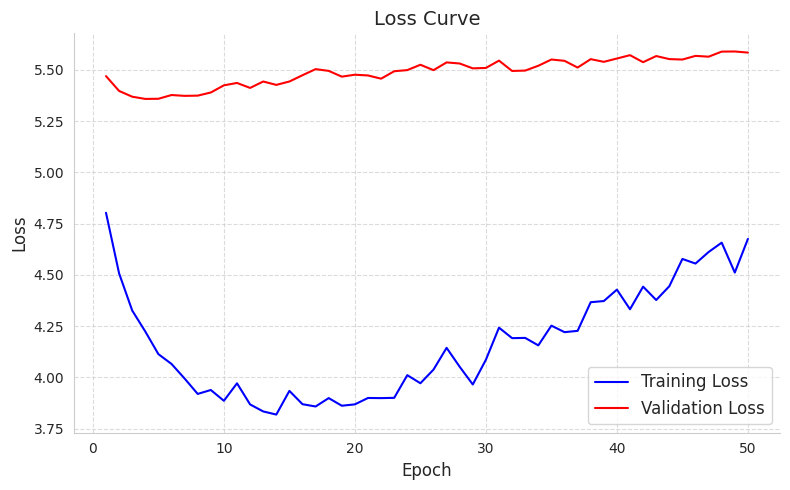

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
epochs = range(1, num_epochs + 1)

sns.lineplot(x=epochs, y=train_losses_per_epoch, label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=val_losses_per_epoch, label='Validation Loss', color='red')


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=14)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()

plt.tight_layout()
plt.show()

In [ ]:
def generate_text(
    model,
    prompt_text,  # list of tokens OR raw string
    encoder,
    max_new_tokens=20,
    temperature=1.0
):
    model.eval()

    if isinstance(prompt_text, str):
        prompt_tokens = encoder.encode(prompt_text)
    else:
        prompt_tokens = list(prompt_text)

    prompt_tokens = torch.tensor([prompt_tokens], dtype=torch.long, device=device)
    # shape: (1, prompt_length)

    generated = prompt_tokens.squeeze(0).tolist()

    hidden = [torch.zeros(1, model.hidden_size, device=device)
              for _ in range(model.num_layers)]

    # Feed the entire prompt (except the last token) to update hidden states
    with torch.no_grad():
        for t in range(prompt_tokens.size(1) - 1):
            x_t = prompt_tokens[:, t]           
            x_embed = model.embed(x_t)          
            _, hidden = model.rnn(x_embed, hidden)

    current_token = prompt_tokens[:, -1]        

    for _ in range(max_new_tokens):
        with torch.no_grad():
            x_embed = model.embed(current_token) 
            out, hidden = model.rnn(x_embed, hidden)  
            logits = model.fc(out)             

            #apply temperature
            logits = logits / temperature

            probs = F.softmax(logits, dim=-1).squeeze().cpu().numpy()    # Convert to probabilities (1D array of size vocab_size)

            next_token_id = np.random.choice(len(probs), p=probs)
            generated.append(next_token_id)

            #update current_token
            current_token = torch.tensor([[next_token_id]], device=device)

    #convert all tokens (prompt + newly generated) back to text
    generated_text = encoder.decode(generated)
    return generated_text

In [28]:
seed_text = "To be or not to"
output = generate_text(model, seed_text, encoder, max_new_tokens=20, temperature=0.8)
print(output)

To be or not to won., I
,
We will be, it..

First Musician:


In [ ]:
def evaluate_and_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_count = 0  # number of tokens predicted

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)  # (batch_size, seq_length)
            y_batch = y_batch.to(device)  # (batch_size)

            # Standard forward pass
            logits, _ = model(x_batch)

            # Suppose we only want the last time step’s logits
            # shape: [batch_size, seq_length, vocab_size]
            last_logits = logits[:, -1, :]  # [batch_size, vocab_size]

            # Compute cross-entropy
            loss = criterion(last_logits, y_batch)

            # Accumulate weighted sum
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_count += batch_size

    avg_loss = total_loss / total_count
    ppl = math.exp(avg_loss)  # perplexity = exp(cross-entropy)
    return avg_loss, ppl


In [30]:
test_loss, test_ppl = evaluate_and_perplexity(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Perplexity: {test_ppl:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 5.5845 | Test Perplexity: 266.2694


In [31]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            logits, _ = model(x_batch)
            # shape: [batch_size, seq_length, vocab_size]
            last_logits = logits[:, -1, :]
            predictions = torch.argmax(last_logits, dim=-1)  # [batch_size]

            correct += (predictions == y_batch).sum().item()
            total   += y_batch.size(0)

    return correct / total  # accuracy


In [32]:
test_acc = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2183


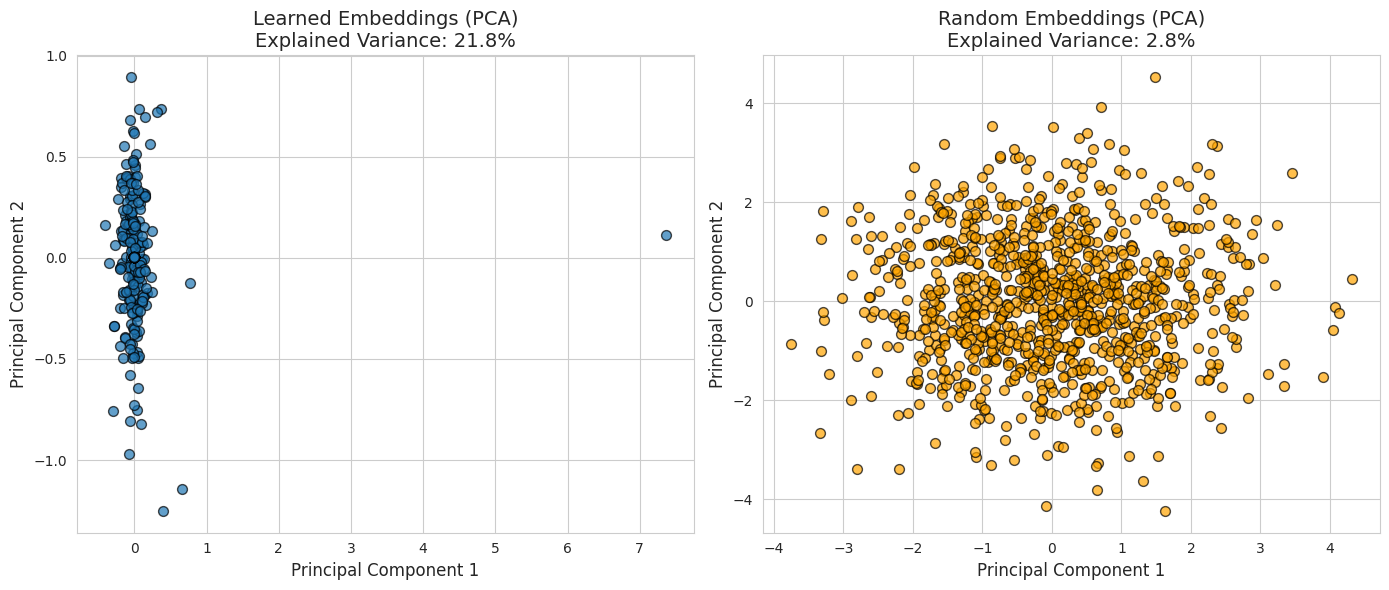

In [ ]:


# Extract learned embeddings from the trained model
learned_embeddings = model.embed.weight.data.cpu().numpy()

# Create a randomly initialized embedding matrix of the same shape
random_embeddings = torch.randn_like(model.embed.weight.data).cpu().numpy()

# Optionally, sample a subset of token embeddings for clarity in the plot
num_samples = 1000  # adjust as needed
indices = np.random.choice(learned_embeddings.shape[0], size=num_samples, replace=False)
learned_subset = learned_embeddings[indices]
random_subset  = random_embeddings[indices]

# Perform PCA separately on both sets to reduce to 2 dimensions
pca_learned = PCA(n_components=2)
learned_pca = pca_learned.fit_transform(learned_subset)
explained_variance_learned = np.sum(pca_learned.explained_variance_ratio_) * 100

pca_random = PCA(n_components=2)
random_pca = pca_random.fit_transform(random_subset)
explained_variance_random = np.sum(pca_random.explained_variance_ratio_) * 100

# Create side-by-side scatter plots using subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Learned Embeddings
axes[0].scatter(learned_pca[:, 0], learned_pca[:, 1],
                alpha=0.7, edgecolors='k', s=50)
axes[0].set_title(f'Learned Embeddings (PCA)\nExplained Variance: {explained_variance_learned:.1f}%', fontsize=14)
axes[0].set_xlabel('Principal Component 1', fontsize=12)
axes[0].set_ylabel('Principal Component 2', fontsize=12)

# Plot for Random Embeddings
axes[1].scatter(random_pca[:, 0], random_pca[:, 1],
                alpha=0.7, color='orange', edgecolors='k', s=50)
axes[1].set_title(f'Random Embeddings (PCA)\nExplained Variance: {explained_variance_random:.1f}%', fontsize=14)
axes[1].set_xlabel('Principal Component 1', fontsize=12)
axes[1].set_ylabel('Principal Component 2', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:


gc.collect()
torch.cuda.empty_cache()


In [36]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, clip=5.0):
    """
    Basic training loop for one epoch (no scheduled sampling in this minimal example).
    """
    model.train()
    total_loss = 0.0
    total_samples = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        # Forward
        logits, _ = model(x_batch)  # (batch_size, seq_length, vocab_size)
        # We'll take the logits at the last time-step
        last_logits = logits[:, -1, :]  # (batch_size, vocab_size)
        loss = criterion(last_logits, y_batch)

        # Backward
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        total_samples += x_batch.size(0)

    return total_loss / total_samples

In [48]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits, _ = model(x_batch)
            last_logits = logits[:, -1, :]
            loss = criterion(last_logits, y_batch)

            total_loss += loss.item() * x_batch.size(0)
            total_samples += x_batch.size(0)

    if total_samples == 0:
        return float('inf')  # or raise an error
    return total_loss / total_samples


In [49]:
def train_and_evaluate(hparams, train_dataset, val_dataset, device):
    # Unpack hyperparameters
    vocab_size = hparams["vocab_size"]
    embed_size = hparams["embed_size"]
    hidden_size = hparams["hidden_size"]
    num_layers  = hparams["num_layers"]
    dropout     = hparams["dropout"]
    batch_size  = hparams["batch_size"]
    lr          = hparams["lr"]
    weight_decay = hparams["weight_decay"]
    epochs      = hparams["epochs"]

    # Build DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    # Create model
    model = StackedVanillaRNNModel(
        vocab_size=vocab_size,
        embed_size=embed_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss   = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Make sure we return the last computed val_loss (which should be a float)
    return val_loss, model


In [ ]:
def random_search(
    train_dataset,
    val_dataset,
    vocab_size,
    device,
    n_trials=10,
    seed=42
):
    """
    Perform random search over hyperparameters.
    Returns a tuple (best_hparams, best_val_loss, best_model).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)

    # Define the hyperparameter search space
    # Each key in this dict is a hyperparam name,
    # and the value is a Python list from which we randomly sample.
    param_space = {
        "embed_size":   [64, 128, 256],
        "hidden_size":  [128, 256, 512],
        "num_layers":   [1, 2, 3],
        "dropout":      [0.0, 0.2, 0.4],
        "batch_size":   [256, 512, 1024],
        "lr":           [1e-3, 5e-4, 1e-4],
        "weight_decay": [1e-5, 1e-6, 0.0],
        "epochs":       [3, 5],  # smaller for random search
    }

    best_val_loss = float("inf")
    best_hparams  = None
    best_model    = None

    for trial in range(n_trials):
        sampled_hparams = {
            "vocab_size": vocab_size,
            "embed_size":   random.choice(param_space["embed_size"]),
            "hidden_size":  random.choice(param_space["hidden_size"]),
            "num_layers":   random.choice(param_space["num_layers"]),
            "dropout":      random.choice(param_space["dropout"]),
            "batch_size":   random.choice(param_space["batch_size"]),
            "lr":           random.choice(param_space["lr"]),
            "weight_decay": random.choice(param_space["weight_decay"]),
            "epochs":       random.choice(param_space["epochs"]),
        }

        print(f"\n===== TRIAL {trial+1}/{n_trials} =====")
        print("Hyperparams:", sampled_hparams)

        val_loss, trained_model = train_and_evaluate(sampled_hparams, train_dataset, val_dataset, device)
        print(f"Validation Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss   = val_loss
            best_hparams    = sampled_hparams
            best_model      = trained_model

    return best_hparams, best_val_loss, best_model


In [ ]:
split_ratio = 0.9
split_index = int(len(train_dataset)*split_ratio)
train_dataset_split = torch.utils.data.Subset(train_dataset, range(0, split_index))
val_dataset_split   = torch.utils.data.Subset(train_dataset, range(split_index, len(train_dataset)))

best_hparams, best_val_loss, best_model = random_search(
    train_dataset_split,
    val_dataset_split,
    vocab_size=vocab_size,
    device=device,
    n_trials=5 
)

print("\nBest hyperparams found:")
print(best_hparams)
print(f"Best validation loss = {best_val_loss:.4f}")



===== TRIAL 1/5 =====
Hyperparams: {'vocab_size': 50257, 'embed_size': 256, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4, 'batch_size': 512, 'lr': 0.001, 'weight_decay': 1e-05, 'epochs': 3}
Epoch 1/3 | Train Loss: 6.0254 | Val Loss: 5.8212
Epoch 2/3 | Train Loss: 4.8545 | Val Loss: 5.4386
Epoch 3/3 | Train Loss: 4.4964 | Val Loss: 5.2976
Validation Loss = 5.2976

===== TRIAL 2/5 =====
Hyperparams: {'vocab_size': 50257, 'embed_size': 256, 'hidden_size': 128, 'num_layers': 3, 'dropout': 0.4, 'batch_size': 1024, 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 5}
Epoch 1/5 | Train Loss: 6.8060 | Val Loss: 6.6610
Epoch 2/5 | Train Loss: 6.3656 | Val Loss: 6.6910
Epoch 3/5 | Train Loss: 6.3586 | Val Loss: 6.6959
Epoch 4/5 | Train Loss: 6.2527 | Val Loss: 6.5584
Epoch 5/5 | Train Loss: 6.0873 | Val Loss: 6.4895
Validation Loss = 6.4895

===== TRIAL 3/5 =====
Hyperparams: {'vocab_size': 50257, 'embed_size': 64, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'batch_size': 256, 'lr': 0

In [52]:
test_loader = DataLoader(test_dataset, batch_size=best_hparams["batch_size"], shuffle=False)
test_loss = evaluate(best_model, test_loader, nn.CrossEntropyLoss(), device)
test_ppl  = np.exp(test_loss)

print(f"Test Loss = {test_loss:.4f}")
print(f"Test Perplexity = {test_ppl:.4f}")


Test Loss = 5.4215
Test Perplexity = 226.2242
